# MNIST example for learning rate finder with gradient accumulation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

/home/davidtvs-nb/lr-finder-rev/py3/pytorch-lr-finder/env/lib/python3.6/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import random
import os
import numpy as np

SEED = 0

def reset_seed(seed):
    """
    ref: https://forums.fast.ai/t/accumulating-gradients/33219/28
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


## Model

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Dataset

In [4]:
data_folder = '../data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(data_folder, train=True, download=True, transform=transform)
testset = datasets.MNIST(data_folder, train=False, download=True, transform=transform)

DESIRED_BATCH_SIZE = 256

## Training loss


Learning rate search finished. See the graph with {finder_name}.plot()


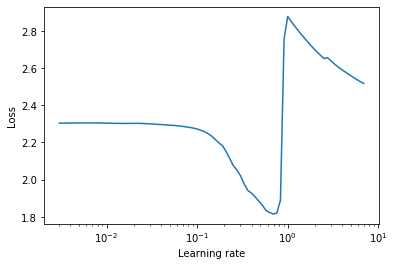

In [5]:
reset_seed(SEED)
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

## Training loss and gradient accumulation

- Desired `batch_size`: 256
- Real `batch_size`: 8

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



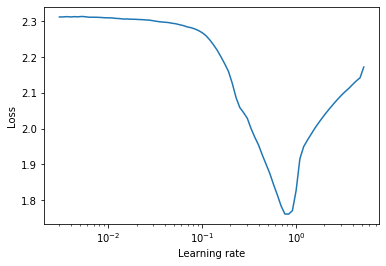

In [6]:
reset_seed(SEED)
batch_size = 8
accumulation_steps = DESIRED_BATCH_SIZE//batch_size

# re-create `DataLoader` to apply the new `batch_size`
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp', accumulation_steps=accumulation_steps)
lr_finder.plot()
lr_finder.reset()

## Validation loss


Learning rate search finished. See the graph with {finder_name}.plot()


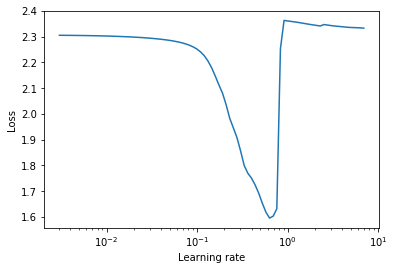

In [7]:
reset_seed(SEED)

# re-create `DataLoader` to apply the new `batch_size`
trainloader = DataLoader(trainset, batch_size=DESIRED_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=DESIRED_BATCH_SIZE*2, shuffle=False)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()

## Validation loss and gradient accumulation

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


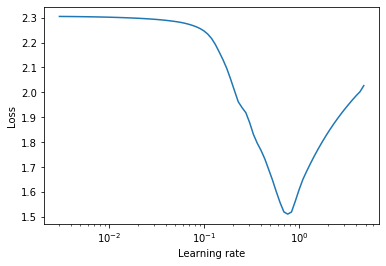

In [8]:
reset_seed(SEED)
batch_size = 8
accumulation_steps = DESIRED_BATCH_SIZE//batch_size

# re-create `DataLoader` to apply the new `batch_size`
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=DESIRED_BATCH_SIZE*2, shuffle=False)

device = torch.device('cuda')
model = ConvNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=100, step_mode='exp', accumulation_steps=accumulation_steps)
lr_finder.plot()
lr_finder.reset()